In [ ]:
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.layers import Dense, Activation, Dropout
from sklearn.metrics import confusion_matrix
import cv2
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
# for machine learning we cannot have any data
# or text so we conver it to numbers hance used Label Encoder
from sklearn.preprocessing import MinMaxScaler
#gets feature within a range
import numpy as np
#numerical
import mahotas
# Computer vision toolbox contains algorithm
#for feature extraction in general and its works faster
import cv2
#open CV library
import os
#Operating system
import h5py
#let you store huge amounts of numerical data,
#and easily manipulate that data from NumPy
from pathlib import Path
#handle filesystem paths
import json
#to save in json format
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib 
from dbn.tensorflow import SupervisedDBNClassification

2021-11-02 19:39:30.131119: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-02 19:39:30.131161: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/navneeth/.local/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/navneeth/.local/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:167: 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
ls

copy_of_mainfile.ipynb       Figure_1.png      requirements.txt
Database/                    LICENSE           setup.py
data.txt                     main_file.py      Test/
dbn/                         Main_GUI.py       test_code.py
dbn_chk.py                   new_data.py       test_efficiency.py
deep-belief-network-master/  Output/
dnn.pk1                      random_model.pkl


In [10]:
!pip3 install mahotas

     |████████████████████████████████| 5.7 MB 6.2 MB/s 


In [15]:
!pip3 install numpy --upgrade

     |████████████████████████████████| 15.7 MB 56 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [10]:
!python3 main_file.py

2021-11-02 14:50:39.773836: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-02 14:50:39.773916: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5ffe3736087a): /proc/driver/nvidia/version does not exist
['Non_Diseased', 'diseased']
/content/drive/MyDrive/SKIN DNN
/content/drive/MyDrive/SKIN DNN/dbn/tensorflow:filecount:2,total size:21669
/content/drive/MyDrive/SKIN DNN/dbn/__pycache__:filecount:12,total size:87297
/content/drive/MyDrive/SKIN DNN/Database/diseased:filecount:44,total size:22467442
/content/drive/MyDrive/SKIN DNN/Database/Non_Diseased:filecount:60,total size:33143751
/content/drive/MyDrive/SKIN DNN/deep-belief-network-master/dbn:filecount:4,total size:31847
/content/drive/MyDrive/SKIN DNN/deep-belief-network-master/examples:filecount:5,total size:7490
0
[STATUS] processed folder: Non_Diseased
inner loop done
1
[S

In [12]:
import tensorflow as tf
import keras

In [14]:
keras.__version__

'2.6.0'

In [ ]:
train_path='Database'
fixed_size=tuple((256,256))
 
#total number of bins for histogram
bins=8
#train_test_split size
test_size=0.10
#is the seed we keep to reproduce
#same results everytime we run this scrpit
seed=9

In [5]:
cd MyDrive


/content/drive/MyDrive


In [7]:
cd SKIN DNN

/content/drive/MyDrive/SKIN DNN


In [ ]:
def folders_in_path(path): #takes path as input
    if not Path.is_dir(path): #checks if path exsist
        raise ValueError("argument is not directory") #produses error
        #if not in directory
    yield from filter(Path.is_dir,path.iterdir())
def folders_in_depth(path,depth):
    if 0>depth:
        raise ValueError("depth smaller 0")
    if 0==depth:
        yield from folders_in_path(path)
    else:
        for folder in folders_in_path(path):
            yield from folders_in_depth(folder,depth-1)
def files_in_path(path):
    if not Path.is_dir(path):
        raise ValueError("argument is not a directory")
    yield from filter(Path.is_file,path.iterdir())
def sum_file_size(filepaths):
    return sum([filep.stat().st_size for filep in filepaths])
#%% FEATURE EXTRACTION
#Hu moments
# feature descriptor-1: Hu Moments 7 feature
def fd_hu_moments(image):
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    feature=cv2.HuMoments(cv2.moments(image)).flatten()
    return feature
#feature descriptor-1:
def fd_haralick(image): #glcm feature
#convert the image to grayscale
    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
# compute the haralick texture feature vector
    haralick=mahotas.features.haralick(gray).mean(axis=0)
#return the result
    return haralick

#feature-descriptor-3: Color Histogram

def fd_histogram(image,mask=None):
    #convert the image to HSV color-space
    image=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    #compute the color histogram
    hist=cv2.calcHist([image],[0,1,2],None,[bins,bins,bins],
                      [0,256,0,256,0,256])
    #normalize the histogram
    cv2.normalize(hist,hist)
    #return the histogram
    return hist.flatten()

In [ ]:
train_labels=os.listdir(train_path) #take training path labels
train_labels.sort() #sort the labels
print(train_labels) #primt the lables
global_features=[] #initialize variable to combine all features
labels=[] #create label variables so as to decode text to number
total=0 #initialize
tot_file=[] #initialize
count=1 #start count to check number of images
i=0
j=0
k=0
print(Path.cwd()) #gives the current path

['Non_Diseased', 'diseased']
/home/navneeth/Desktop/SKIN DNN


In [ ]:
for folder in folders_in_depth(Path.cwd(),1):
        #first loop will pick the first foldend then next folder
        files=list(files_in_path(folder)) #list all files in folder
        file=len(files) #length of files
        tot_file.append(file) #because we are running for all folder
        # we are appending all files in tot_file at the end we
        #shall get the list of number of files in the folder
        #we are doing this because every folder has different number of files
        #at the end when we are trainig all class of disease have to be
        #trained equally, hence find the least number of images in the folder
        #and then train accordingly
        total_size=sum_file_size(files)
        #total size of files
        count=count+1 #check total number of files executed
        print(f'{folder}:filecount:{len(files)},total size:{total_size}')

/home/navneeth/Desktop/SKIN DNN/dbn/tensorflow:filecount:2,total size:21669
/home/navneeth/Desktop/SKIN DNN/dbn/__pycache__:filecount:12,total size:87237
/home/navneeth/Desktop/SKIN DNN/Database/diseased:filecount:44,total size:22467442
/home/navneeth/Desktop/SKIN DNN/Database/Non_Diseased:filecount:60,total size:33143751
/home/navneeth/Desktop/SKIN DNN/deep-belief-network-master/dbn:filecount:4,total size:31847
/home/navneeth/Desktop/SKIN DNN/deep-belief-network-master/examples:filecount:5,total size:7490


In [ ]:
tot_file.sort() #sort files based on ascending order
num=tot_file[1] #Index 0 is junkhence extract index 1
images_per_class=40 #consider number of images per class
#%%START WITH TRAINING
#for tr_name in range(0,2):
 

In [ ]:
count=0    
while count <=1:
    tr_name=count
    print(tr_name)
    dir=train_path+'/'+train_labels[tr_name]
    current_label=train_labels[tr_name]
    print("[STATUS] processed folder: {}".format(current_label))
    k=1
    #print(dir)
    file_sub_folder=os.listdir(dir) 
    for x in range(0,images_per_class):
        file=os.getcwd()+'//'+dir +'//'+ file_sub_folder[x]
        image= cv2.imread(file) #read image
        image=cv2.resize(image,fixed_size) #resize image
        fv_hu_moments=fd_hu_moments(image)
        fv_haralick=fd_haralick(image)
        fv_histogram=fd_histogram(image)
        global_feature=np.hstack([fv_histogram,fv_haralick,fv_hu_moments])
        global_features.append(global_feature)
        labels.append(current_label)
        i+=1
        k+=1    
    print('inner loop done')
    count=count+1
print("[STATUS] complete global feature extraction...")
#print('outer loop ')
#get the overall feature vector size
print("[STATUS]featurevector size{}".format(np.array(global_features).shape))
#get the overall training label size
print("[STATUS] training labels{}".format(np.array(labels).shape))
#%%LABEL ENCODING

#encode the target labels
targetNames=np.unique(labels)
le=LabelEncoder()
target=le.fit_transform(labels) #this steps sets label form 0 to..n based
#on number of labels for us there are 14 label starting from 0
print("[STATUS] target labels:{}".format(target))
print("[STATUS] target labels shape:{}".format(target.shape))
print("[STATUS] training labels encoded...")
#%%FEATURE NORMALIZATION
#normalize the feature vector in the range(0 -1)

scaler=MinMaxScaler(feature_range=(0,1))
rescaled_features=scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

0
[STATUS] processed folder: Non_Diseased
inner loop done
1
[STATUS] processed folder: diseased
inner loop done
[STATUS] complete global feature extraction...
[STATUS]featurevector size(80, 532)
[STATUS] training labels(80,)
[STATUS] target labels:[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[STATUS] target labels shape:(80,)
[STATUS] training labels encoded...
[STATUS] feature vector normalized...


[STATUS] end of feature extraction ...


/home/navneeth/.local/lib/python3.8/site-packages/sklearn/decomposition/online_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
/home/navneeth/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/navneeth/.local/lib/python3.8/site-packages/sklearn/feature_selection/rfe.py:167: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not mo

[False  True  True  True  True  True False False  True  True]
[2 1 1 1 1 1 3 4 1 1]
Best alpha using built-in LassoCV: 0.000095
Best score using built-in LassoCV: 0.274561
Lasso picked 8 variables and eliminated the other 2 variables


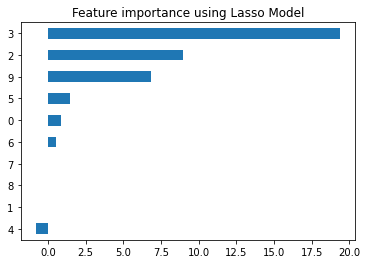

In [ ]:
#%% SAVE THE DATA FOR TRAINING

h5f_data=h5py.File('Output/data.h5', 'w')
h5f_data.create_dataset('dataset_1',data=np.array(rescaled_features))
h5f_data.close()
h5f_label=h5py.File('Output/labels.h5', 'w')
h5f_label.create_dataset('dataset_1',data=np.array(target))
h5f_label.close()


#%% SAVE LABEL IN JSON FORMAT
#do this just to display output when we test
with open('data.txt','w') as outfile:
     json.dump(train_labels, outfile)
#%% CLOSE
print("[STATUS] end of feature extraction ...")
#%% Feature 
model = LinearRegression()
x = pd.DataFrame(global_features)
y = pd.DataFrame(target)
#Initializing RFE model
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
rfe = RFE(model, 7)
x1=x.iloc[:,0:10] 
#Transforming data using RFE
X_rfe = rfe.fit_transform(x1,y)  
#Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)
reg = LassoCV()
reg.fit(x1, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(x1,y))
coef = pd.Series(reg.coef_, index = x1.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
imp_coef = coef.sort_values()
imp_coef.plot(kind = "barh")
import matplotlib.pyplot as plt 
plt.title("Feature importance using Lasso Model")
plt.show()

In [ ]:
import pandas as pd
    
x = pd.DataFrame(global_features)
y = pd.DataFrame(target)
complete_feat=pd.concat([x,y],axis=1)
X=x.iloc[:,0:15] 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state = 9)

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=15, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(24, activation='tanh'))
model.add(Dense(24, activation='relu'))
model.add(Dense(12, activation='tanh'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history=model.fit(X_train, Y_train, epochs=100, batch_size=20)
_, accuracy = model.evaluate(X_test,Y_test)
print('Accuracy: %.2f' % (accuracy*100))

2021-11-02 19:40:14.510034: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
3/3 [==============================] - 2s 6ms/step - loss: 0.6942 - accuracy: 0.4464
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5536
Epoch 3/100
3/3 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.6071
Epoch 4/100
3/3 [==============================] - 0s 6ms/step - loss: 0.6908 - accuracy: 0.5893
Epoch 5/100
3/3 [==============================] - 0s 6ms/step - loss: 0.6897 - accuracy: 0.5893
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 0.6882 - accuracy: 0.5893
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 0.6866 - accuracy: 0.5893
Epoch 8/100
3/3 [==============================] - 0s 8ms/step - loss: 0.6839 - accuracy: 0.6429
Epoch 9/100
3/3 [==============================] - 0s 6ms/step - loss: 0.6806 - accuracy: 0.7500
Epoch 10/100
3/3 [==============================] - 0s 6ms/step - loss: 0.6763 - accuracy: 0.7321
Epoch 11/100
3/3 [===========

3/3 [==============================] - 0s 4ms/step - loss: 0.1820 - accuracy: 0.9464
Epoch 85/100
3/3 [==============================] - 0s 4ms/step - loss: 0.1298 - accuracy: 0.9821
Epoch 86/100
3/3 [==============================] - 0s 4ms/step - loss: 0.2101 - accuracy: 0.9286
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.1765 - accuracy: 0.9464
Epoch 88/100
3/3 [==============================] - 0s 4ms/step - loss: 0.1783 - accuracy: 0.9286
Epoch 89/100
3/3 [==============================] - 0s 4ms/step - loss: 0.1462 - accuracy: 0.9464
Epoch 90/100
3/3 [==============================] - 0s 6ms/step - loss: 0.1415 - accuracy: 0.9286
Epoch 91/100
3/3 [==============================] - 0s 6ms/step - loss: 0.1807 - accuracy: 0.9286
Epoch 92/100
3/3 [==============================] - 0s 5ms/step - loss: 0.1917 - accuracy: 0.9286
Epoch 93/100
3/3 [==============================] - 0s 5ms/step - loss: 0.2634 - accuracy: 0.9107
Epoch 94/100
3/3 [===============

In [ ]:
predict_x=model.predict(X_test)
preds=np.argmax(predict_x,axis=1)

cnf=confusion_matrix(Y_test, preds)        
print(cnf)

[[28  0]
 [20  0]]


In [ ]:
X_train1=X_train.reset_index(drop=True) 
Y_train1=Y_train.reset_index(drop=True) 
model = SupervisedDBNClassification(hidden_layers_structure=[200,200],
learning_rate_rbm=0.01,
learning_rate=0.1,
n_epochs_rbm=20,
n_iter_backprop=20,
batch_size=30,
activation_function='relu')
scale = np.max(X_train)
X_train /= scale
X_test /= scale

mean = np.std(X_train)
X_train -= mean
X_test -= mean
nb_classes= Y_train.shape[1]
input_dim = X_train.shape[1]

In [ ]:
model = Sequential()
model.add(Dense(200, input_dim=input_dim))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# we'll use categorical xent for the loss, and RMSprop as the optimizer
model.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [ ]:
print("Training...")
model.fit(X_train, Y_train, epochs=20, batch_size=30)

Training...
Epoch 1/20
4/4 [==============================] - 1s 3ms/step - loss: 0.6725
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6176
Epoch 3/20
4/4 [==============================] - 0s 4ms/step - loss: 0.5793
Epoch 4/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5491
Epoch 5/20
4/4 [==============================] - 0s 4ms/step - loss: 0.5256
Epoch 6/20
4/4 [==============================] - 0s 5ms/step - loss: 0.4968
Epoch 7/20
4/4 [==============================] - 0s 4ms/step - loss: 0.4786
Epoch 8/20
4/4 [==============================] - 0s 4ms/step - loss: 0.4646
Epoch 9/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4540
Epoch 10/20
4/4 [==============================] - 0s 4ms/step - loss: 0.4419
Epoch 11/20
4/4 [==============================] - 0s 4ms/step - loss: 0.4214
Epoch 12/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4218
Epoch 13/20
4/4 [==============================] - 0s 6ms/ste

In [ ]:
print("Generating test predictions...")
# preds = model.predict_classes(X_test, verbose=0)
predict_x=model.predict(X_test)
preds=np.argmax(predict_x,axis=1)

cnf=confusion_matrix(Y_test, preds)        
print(cnf)

Generating test predictions...
[[28  0]
 [20  0]]
